# 1- Importing & setup

We first start by importing all the libraries

In [2]:
from figures_handler import method_colors as method_colors
from figures_handler import method_names as method_names
from figures_handler import colors as colors
import matplotlib.patches as mpatches
from pandas.plotting import table
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import figures_handler as fh
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

Then, we load the libraries and the experiments

In [3]:
# get the project root
dir_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(dir_path, os.pardir))

experiment_directory = os.path.join(project_root, 'experiments_settings', "experiments_meta_helpers.csv")
data_folder, results_directory, matches_directory, libraries, library_names = fh.get_basic_data(project_root)

display(libraries[['Library', 'short_name']])

,Library,short_name
0,GNPS-MSMLS,lib1
1,GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE,lib2
2,GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE,lib3
3,BERKELEY-LAB,lib4


# performance of all libraries combined for selected evaluation method

First, all the libraries are combined

In [4]:
methods_data = fh.combine_merged_libraries(library_names, experiment_directory, results_directory)
print("methods are: ", list(methods_data.keys()))

methods are:  ['none', 'sirius', 'msbuddy', 'oracle', 'helpers', 'oracle_nohelper', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']


Then, important variables are selected

In [5]:
cols_compare = ["id_known", "id_unknown"]
cols_val = "average_dist_normalized"
cols_meta = ['shifted', 'matched', 'weight', 'delta', 'peaks', 'num_helpers']
target_methods = ['none', 'helpers', 'oracle', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']

Now, we remove the unwanted pairs (no annotated shifted peaks) from oracle and put that as refrence to filter the rest

In [6]:
pairs_with_at_least_one_annotated_shift = methods_data["oracle"][methods_data["oracle"]["shifted_annotated_ambiguity"] > 0]
# select only id columns
pairs_with_at_least_one_annotated_shift = pairs_with_at_least_one_annotated_shift[["id_known", "id_unknown"]]


pairs_with_at_least_one_helper = methods_data["oracle"][methods_data["oracle"]["num_helpers"] > 0]
# select only id columns
pairs_with_at_least_one_helper = pairs_with_at_least_one_helper[cols_compare]
print(len(methods_data['oracle']), len(pairs_with_at_least_one_annotated_shift), len(pairs_with_at_least_one_helper))

12909 7353 10811


draw the violin plot for all the data in the database

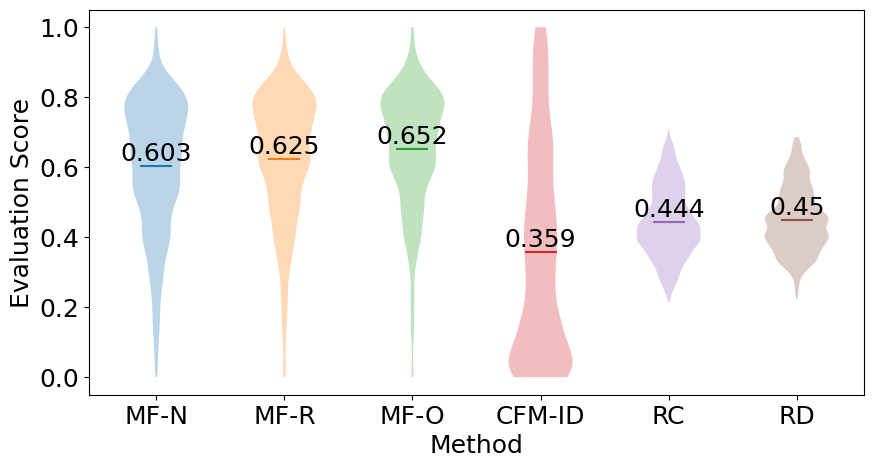

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for index, method in enumerate(target_methods):
    data = methods_data[method]
    # filter out pairs with at least one annotated shift
    data = data.merge(pairs_with_at_least_one_annotated_shift, on=cols_compare)
    if method == 'cfmid':
        data = data[data[cols_val] > 0]
    # select the column to draw
    data = data[cols_val]

    # draw violin plot for each method and show mean value
    ax.violinplot(data, positions=[index], showmeans=True, showextrema=False)
    ax.text(index, np.mean(data), round(np.mean(data), 3), ha='center', va='bottom', fontsize=18)

ax.set_xticks(range(len(target_methods)))
ax.set_xticklabels([method_names[method] for method in target_methods], fontsize=18)
# increase font size of y tics
y_ticks = ax.get_yticks()
y_ticks = [round(y, 2) for y in y_ticks]
ax.set_yticklabels(y_ticks, fontsize=18)
ax.set_ylabel("Evaluation Score", fontsize=18)
ax.set_xlabel("Method", fontsize=18)

plt.show()


# draw the effect of shifted peaks on MF-O and MF-R

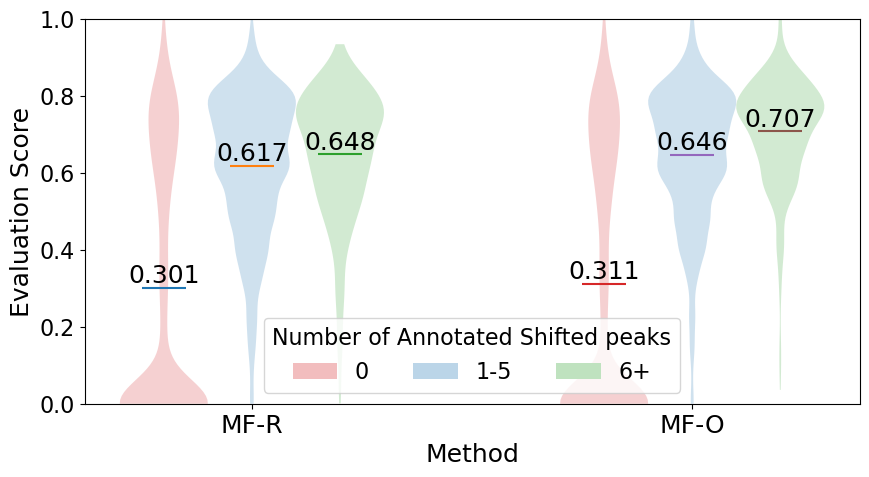

In [8]:
colors = ['#f2bdbe', '#bbd5e8', '#bfe2bf', '#ffd8b6']
target_methods = ['helpers', 'oracle']
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
width = 1
gap_width = 0
step = width*len(target_methods) + gap_width * (len(target_methods)) + 2*(width + gap_width) + 1
# print(step)
for index, method in enumerate(target_methods):
    # print(index, method)
    # select the data
    data = methods_data[method]

    # create a column to store the number of annotated shifts
    data_column = data['shifted_annotated_ratio']*data['shifted']
    data['num_annotated_shifts'] = data_column

    # select rows with id_known and id_unknown in pairs_with_no_shift
    temp_no_shift = data[data['num_annotated_shifts'] == 0]
    # print(len(temp_no_shift))
    scores_no_shift = temp_no_shift['average_dist_normalized']
    # print(scores_no_shift.mean())

    temp_small_shift = data[(data['num_annotated_shifts'] > 0) & (data['num_annotated_shifts'] < 6)]
    scores_small_shift = temp_small_shift['average_dist_normalized']

    temp_large_shift = data[data['num_annotated_shifts'] > 5]
    scores_large_shift = temp_large_shift['average_dist_normalized']

    parts =ax.violinplot(scores_no_shift, positions=[index * step], showmeans=True, showextrema=False, widths=width)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[0])
        pc.set_alpha(0.7)
    # parts['bodies'][0].set_facecolor(colors[0])
    ax.text(index * step, np.mean(scores_no_shift), round(np.mean(scores_no_shift), 3), ha='center', va='bottom', fontsize=18)

    parts2 = ax.violinplot(scores_small_shift, positions=[index * step + width + gap_width], showmeans=True, showextrema=False, widths=width)
    for pc in parts2['bodies']:
        pc.set_facecolor(colors[1])
        pc.set_alpha(0.7)
    ax.text(index * step + width + gap_width, np.mean(scores_small_shift), round(np.mean(scores_small_shift), 3), ha='center', va='bottom', fontsize=18)

    parts3 = ax.violinplot(scores_large_shift, positions=[index * step + 2*(width + gap_width)], showmeans=True, showextrema=False, widths=width)
    for pc in parts3['bodies']:
        pc.set_facecolor(colors[2])
        pc.set_alpha(0.7)
    ax.text(index * step + 2*(width + gap_width), np.mean(scores_large_shift), round(np.mean(scores_large_shift), 3), ha='center', va='bottom', fontsize=18)
    
    # ax.bar(index * step, np.mean(scores_no_shift), width=width, color = colors[0])
    # ax.bar(index * step + width + gap_width, np.mean(scores_small_shift), width=width, color = colors[1])
    # ax.bar(index * step + 2*(width + gap_width), np.mean(scores_large_shift), width=width, color = colors[2])

# set y ticks
ax.set_ylim([0, 1])
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("Evaluation Score", fontsize=18)

# set x ticks
ax.set_xticks(np.arange(len(target_methods)) * step + (width + gap_width))
ax.set_xticklabels([method_names[method] for method in target_methods], fontsize=18)

ax.set_xlabel("Method", fontsize=18)

# add custom legend
ax.bar(0.5, 0, color=colors[0], label="0")
ax.bar(0.5, 0, color=colors[1], label="1-5")
ax.bar(0.5, 0, color=colors[2], label="6+")
# add legend title
ax.legend(fontsize=16, title="Number of Annotated Shifted peaks", title_fontsize=16, loc='lower center', ncol=3)

# make the drawing a function

In [9]:
def draw_performance_violin(methods_data, target_methods, pairs_with_at_least_one_annotated_shift, cols_val, cols_compare, ax):
    for index, method in enumerate(target_methods):
        # print(method, cols_val)
        data = methods_data[method]
        # filter out pairs with at least one annotated shift
        data = data.merge(pairs_with_at_least_one_annotated_shift, on=cols_compare)
        # select the column to draw
        data = data[cols_val]

        # draw violin plot for each method and show mean value
        ax.violinplot(data, positions=[index], showmeans=True, showextrema=False)
        data_mean = np.mean(data)
        ax.text(index, data_mean, str(round(data_mean, 3)), ha='center', va='bottom', fontsize=18)

def draw_across_methods(categories, axs, methods_data, target_methods, pairs_with_at_least_one_annotated_shift, cols_compare, top_ticks=True, bottom_ticks=True, ys_label = "Evaluation Score"):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 19}
    font_labels = {'family' : 'sans-serif',
            'weight' : 'bold',
            'size'   : 22}
    
    for i, category in enumerate(categories):
        # print(category)
        draw_performance_violin(methods_data, target_methods, pairs_with_at_least_one_annotated_shift, category, cols_compare, axs[i])
        if bottom_ticks:
            axs[i].set_xticks(list(range(len(target_methods))))
            axs[i].set_xticklabels([method_names[method] for method in target_methods], fontsize=font['size'])
        else:
            axs[i].set_xticks([])
        if top_ticks:
            title = category.replace("_", "-").capitalize()
            if title == "Average-dist-normalized":
                title = "Average-distance"
            axs[i].set_title(title, font = font)
        # remove top and right spines
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        # set ylim
        axs[i].set_ylim([0, 1])

        if i != 0:
            axs[i].spines['left'].set_visible(False)
            # remove y-axis tick marks
            axs[i].set_yticks([])

            # draw a dashed vertical line at the spine of the left
            axs[i].plot([0, 0], [0, 1], transform=axs[i].transAxes, ls='--', c='black', linewidth=2)
        else:
            axs[i].set_ylabel(ys_label, font = font_labels)
            axs[i].yaxis.set_tick_params(labelsize=font['size'])
    
    if bottom_ticks:
        # write "methods" on the middle of the x-axis
        if len(categories) % 2 == 0:
            middle = len(categories)//2 - 1
            axs[middle].text(len(target_methods) - 1, -0.3, "Methods", font = font_labels)
        else:
            axs[len(categories)//2].set_xlabel("Methods", font = font_labels)


# draw the score across different evaluation methods

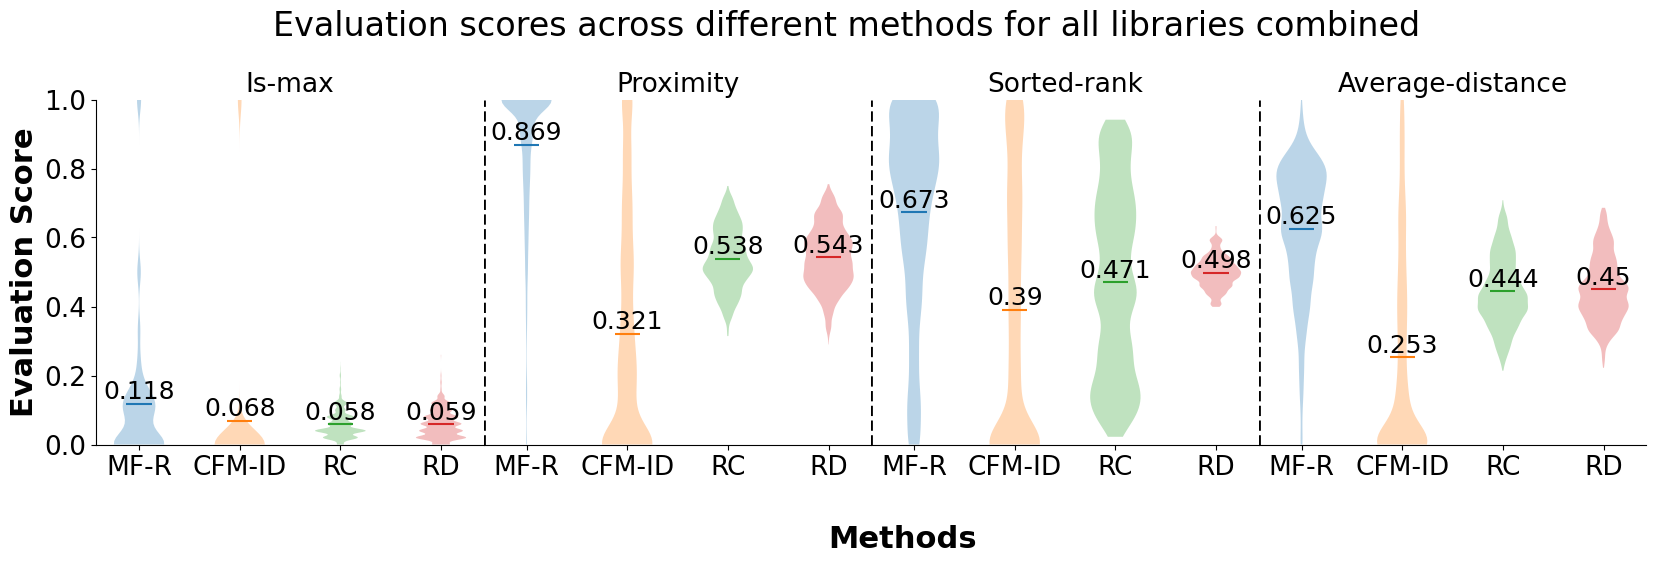

In [10]:
categories = ["is_max", "proximity", "sorted_rank", "average_dist_normalized"]
target_methods = ['helpers', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']
cols_compare = ["id_known", "id_unknown"]
fig, axs = plt.subplots(1, len(categories), figsize=(20, 5))
draw_across_methods(categories, axs, methods_data, target_methods, pairs_with_at_least_one_annotated_shift, cols_compare)
# bring axes closer to each other.
fig.subplots_adjust(hspace=0.1, wspace=0.0)

fig.suptitle("Evaluation scores across different methods for all libraries combined", fontsize=24)

# add space for title
plt.subplots_adjust(top=0.80)

# draw the performance for each library individually

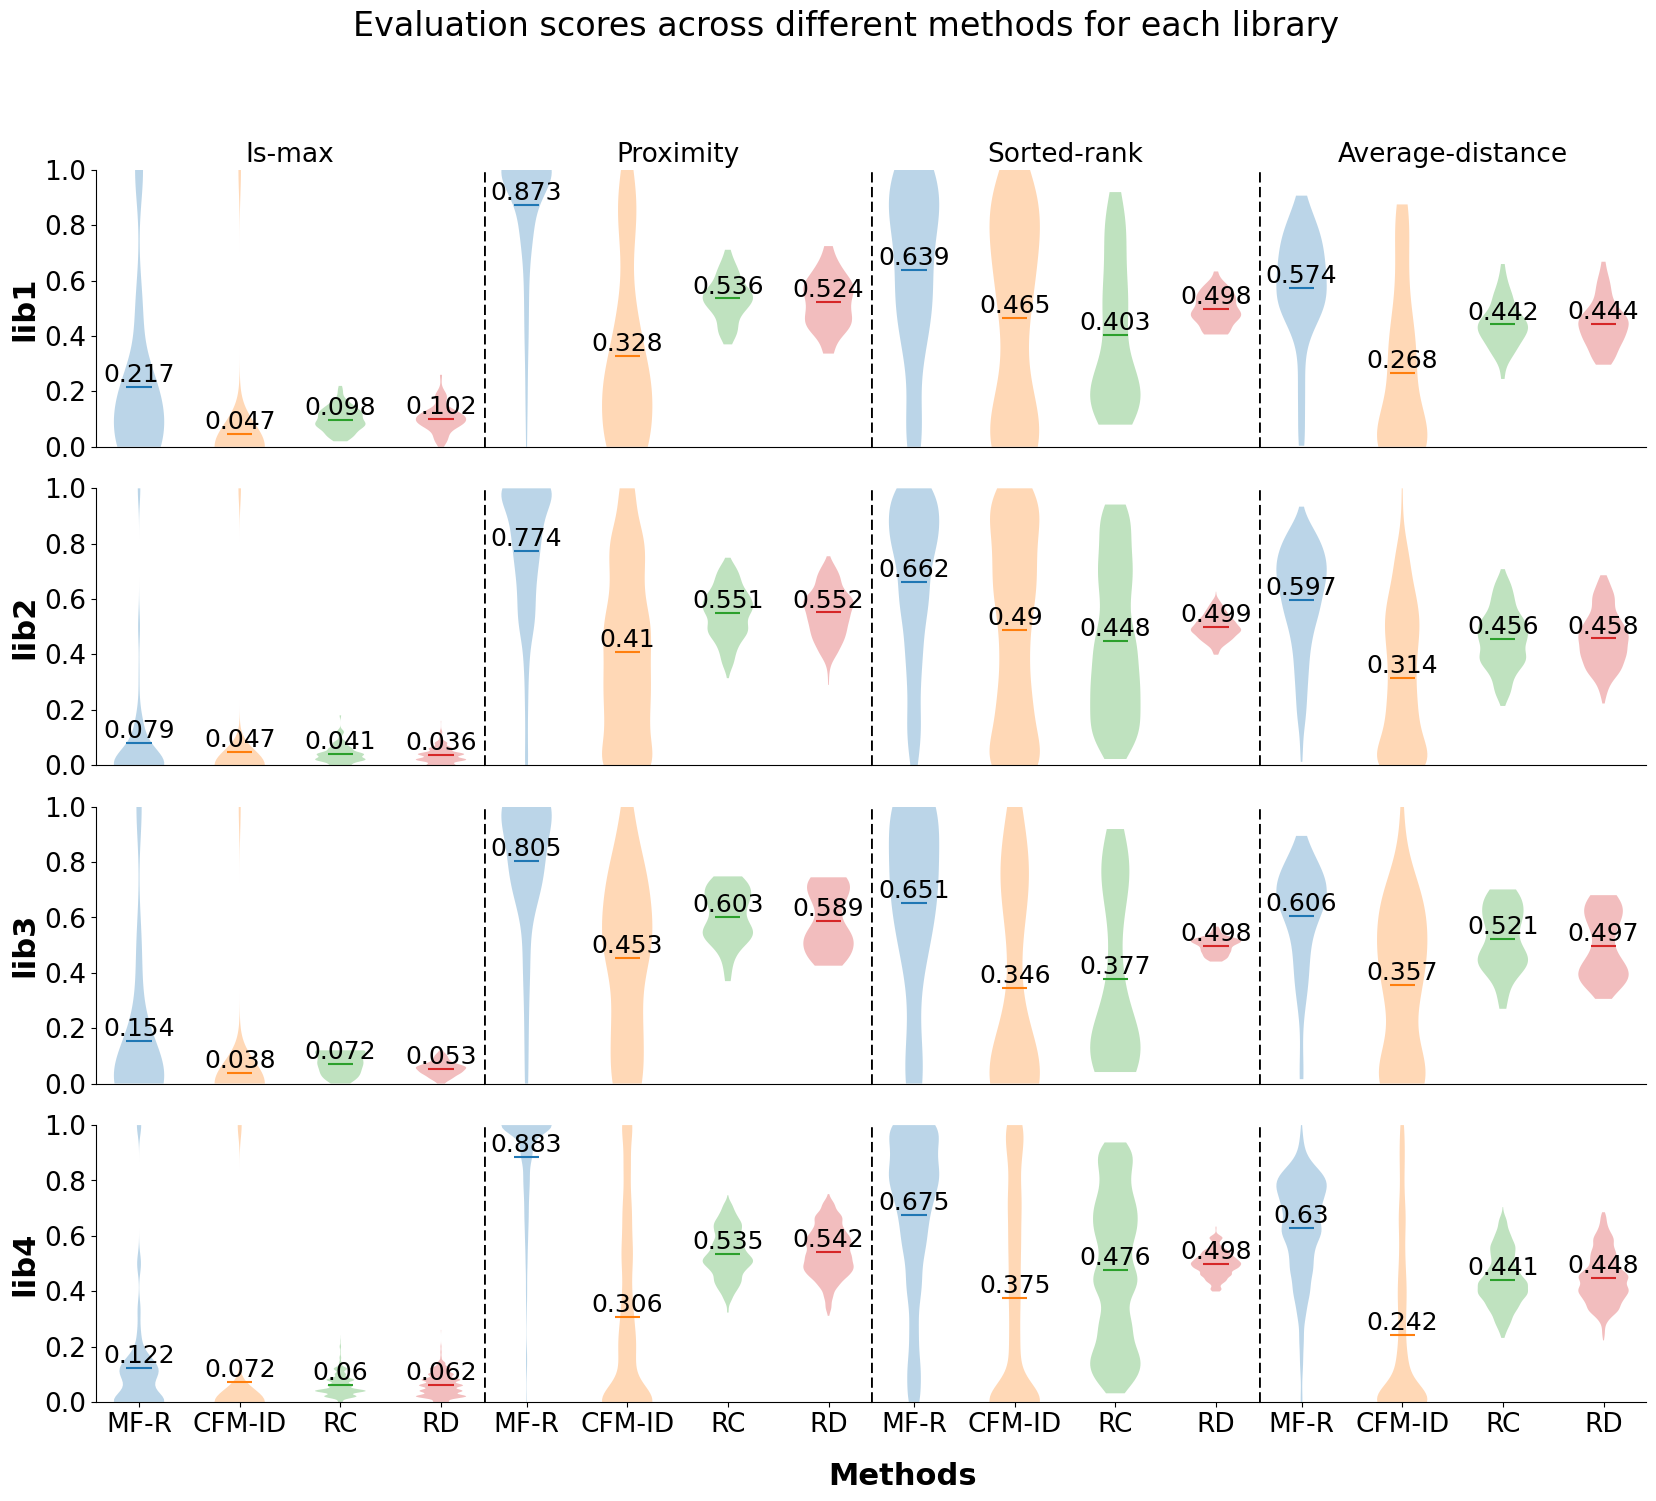

In [11]:
categories = ["is_max", "proximity", "sorted_rank", "average_dist_normalized"]
target_methods = ['helpers', 'cfmid', 'multiple_random_choice', 'multiple_random_distribution']
cols_compare = ["id_known", "id_unknown"]
fig, axs = plt.subplots(len(library_names), len(categories), figsize=(20, 16))
for i, library in enumerate(library_names):
    df, data, methods = fh.get_all(library, experiment_directory, results_directory)
    library_data = {}
    for method in methods:
            library_data[method] = data[methods[method]]
    
    top_ticks = False
    if i == 0:
          top_ticks = True
    bottom_ticks = False
    if i == len(library_names) - 1:
        bottom_ticks = True
    draw_across_methods(categories, axs[i], library_data, target_methods, pairs_with_at_least_one_annotated_shift, cols_compare, top_ticks=top_ticks, bottom_ticks=bottom_ticks, ys_label = library_names[library])
# bring axes closer to each other.
fig.subplots_adjust(hspace=0.15, wspace=0.0)

fig.suptitle("Evaluation scores across different methods for each library", fontsize=24)

# add space for title
# plt.subplots_adjust(top=0.10)
plt.show()

6485 better than RD in 80.72949085024274%
6454  better than RD in 80.34358272127474%


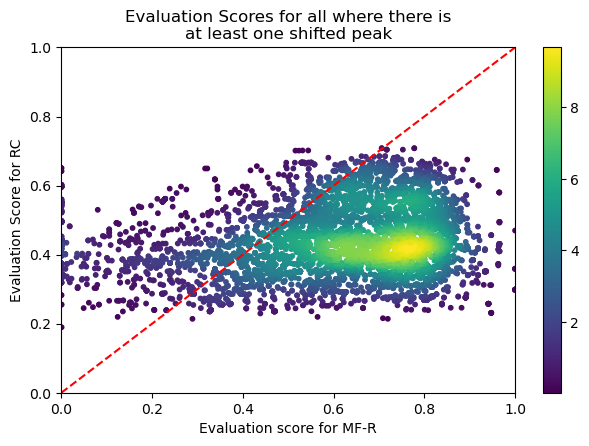

In [27]:
cols_compare = ["id_known", "id_unknown"]
cols_val = "average_dist_normalized"
cols_meta = ['shifted', 'matched', 'weight', 'delta', 'peaks', 'num_helpers', 'shifted_annotated_ambiguity']
target_methods = ['none', 'helpers', 'oracle', 'multiple_random_choice', 'multiple_random_distribution']
target_names = ["MF-H", "MF-O", "RC"]
all_libraries_merged_df = pd.DataFrame()
all_libraries_merged_df_pre_filter = pd.DataFrame()
for library in library_names:
    # print(library)
    df, data, methods = fh.get_all(library, experiment_directory, results_directory)
    #only keep methods in target_methods
    methods = {k: v for k, v in methods.items() if k in target_methods}
    merged_df = fh.create_merged_libraries(data, methods, cols_compare, cols_val, cols_meta)
    all_libraries_merged_df_pre_filter = pd.concat([all_libraries_merged_df_pre_filter, merged_df])
    merged_df = merged_df[merged_df["shifted"] > 0]
    merged_df = merged_df[merged_df["shifted_annotated_ambiguity"] > 0]

    all_libraries_merged_df = pd.concat([all_libraries_merged_df, merged_df])
# merged_df
    
fh.draw_scatter(all_libraries_merged_df['helpers'].values, all_libraries_merged_df['multiple_random_choice'].values, 'Evaluation score for MF-R', 'Evaluation Score for RC', 'all')

better = len(all_libraries_merged_df[all_libraries_merged_df['helpers'] > all_libraries_merged_df['multiple_random_choice']])
print(better, "better than RD in {}%".format((better/len(all_libraries_merged_df)*100)))

better = len(all_libraries_merged_df[all_libraries_merged_df['helpers'] > all_libraries_merged_df['multiple_random_distribution']])
print(better, " better than RD in {}%".format((better/len(all_libraries_merged_df)*100)))

6843 85.18610730735715%
6858 85.37283704718038%


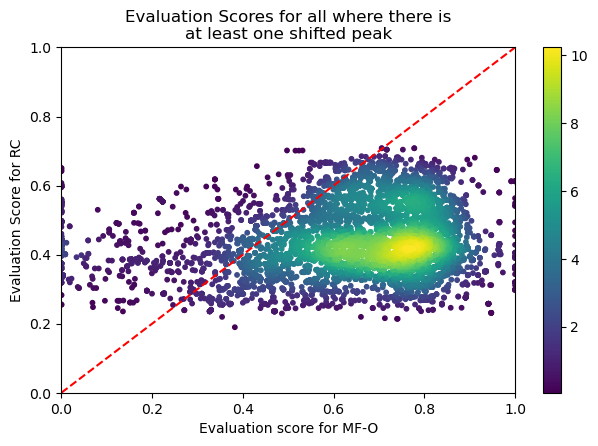

In [28]:
 
fh.draw_scatter(all_libraries_merged_df['oracle'].values, all_libraries_merged_df['multiple_random_choice'].values, 'Evaluation score for MF-O', 'Evaluation Score for RC', 'all')

better = len(all_libraries_merged_df[all_libraries_merged_df['oracle'] > all_libraries_merged_df['multiple_random_choice']])
print(better, "{}%".format((better/len(all_libraries_merged_df)*100)))

better = len(all_libraries_merged_df[all_libraries_merged_df['oracle'] > all_libraries_merged_df['multiple_random_distribution']])
print(better, "{}%".format((better/len(all_libraries_merged_df)*100)))